In [1]:
import os

datadir = '../data/TFI-model/'
os.makedirs(datadir, exist_ok=True)

In [2]:
import netket as nk
from netket.graph import Lattice
from netket.operator.spin import sigmax, sigmay, sigmaz
import json
import jax.numpy as jnp
import numpy as np
def get_TFI_Hamiltonian(L,theta,Lambda,pbc=False):
    """
    Constructs the TFI model Hamiltonian on a square lattice with periodic boundary conditions.

    H = -sum_{<i,j>} (Jxx S^x_i S^x_j + Jyy S^y_i S^y_j + Jzz S^z_i S^z_j)

    Args:
        Jxx: Coupling constant for x-direction
        Jyy: Coupling constant for y-direction
        Jzz: Coupling constant for z-direction
        Lx: Number of sites along x
        Ly: Number of sites along y

    Returns:
        g: NetKet Lattice object
        hi: NetKet Hilbert space
        H: NetKet Hamiltonian operator
    """
    g = nk.graph.Chain(length=L,pbc=pbc)
    hi = nk.hilbert.Spin(s=1/2, N=g.n_nodes)
    def sx(i):
        return np.cos(theta) * sigmax(hi,i) + np.sin(theta) * sigmaz(hi,i)

    def sz(i):
        return np.cos(theta) * sigmaz(hi,i) - np.sin(theta) * sigmax(hi,i)

    H = sum(- Lambda * sx(i) for i in g.nodes())

    for (i,j) in g.edges():
        # Right neighbor
        H += -sz(i)*sz(j)
        
    return g, hi, H

In [6]:
from analysis import *

In [4]:
thetas = np.linspace(0, np.pi/2, 20)
L = 10
lambdas = [0.5, 1.0, 1.5]
ground_states = []

for Lambda in lambdas:
    gs_for_lambda = []
    for theta in thetas:
        _, _, H = get_TFI_Hamiltonian(L, theta, Lambda)
        _, eigenvectors = nk.exact.lanczos_ed(H, k=1, compute_eigenvectors=True)
        psi0 = eigenvectors[:, 0]
        gs_for_lambda.append(psi0)
    ground_states.append(gs_for_lambda)

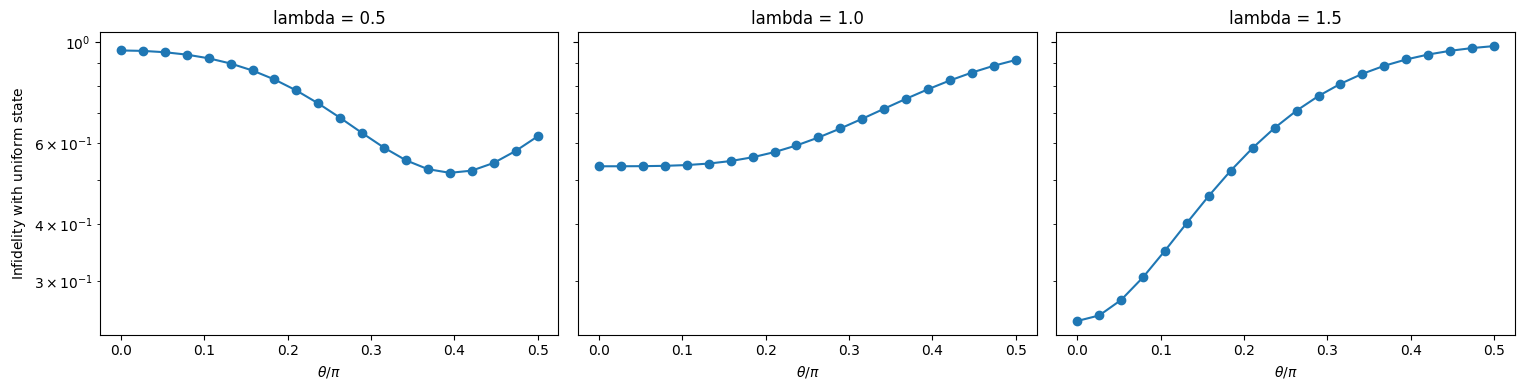

In [7]:
# overlaps = [[uniform_state_overlap(gs) for gs in G] for G in ground_states]
psi_uniform = np.ones(2**L) / np.sqrt(2**L)
infidelities = [[infidelity(gs, psi_uniform) for gs in G] for G in ground_states]
# iprs = [ipr(gs) for gs in ground_states]
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
for i, lam in enumerate(lambdas):
    axs[i].plot(thetas/np.pi, np.array(infidelities[i]), marker='o')
    axs[i].set_title(f'lambda = {lam}')
    axs[i].set_xlabel(r'$\theta/\pi$')
axs[0].set_ylabel(r'$\text{Infidelity with uniform state}$')
plt.tight_layout()
plt.yscale('log')
plt.xlabel(r'$\theta/\pi$')
plt.show()

In [8]:
import optimization

In [9]:
vmc_steps = 1000
learning_rate = 0.002
diag_shift = 1e-4
L = 10

In [10]:
for Lambda in lambdas:
    for theta in thetas:
        _, _, H = get_TFI_Hamiltonian(L, theta, Lambda)

        params = optimization.generate_params(
            alpha=1,
            seed=1234,
            learning_rate=3e-2,
            n_iter=vmc_steps,
            show_progress=False,
            diag_shift=diag_shift,
            Lambda=Lambda,
            theta=theta,
            out=f"../data/TFI-model/rbm_optimization",
        )
        output_file = params["out"] + ".log"
        if os.path.exists(output_file):
            print(f"Skipping Hamiltonian, output file already exists.")
            continue

        out = optimization.optimize_rbm(H, params)
        optimization.write_output(H, out, params)

Skipping Hamiltonian, output file already exists.
Skipping Hamiltonian, output file already exists.
Skipping Hamiltonian, output file already exists.
Skipping Hamiltonian, output file already exists.
Skipping Hamiltonian, output file already exists.
Skipping Hamiltonian, output file already exists.
Skipping Hamiltonian, output file already exists.
Skipping Hamiltonian, output file already exists.
Skipping Hamiltonian, output file already exists.
Skipping Hamiltonian, output file already exists.
Skipping Hamiltonian, output file already exists.
Skipping Hamiltonian, output file already exists.
Skipping Hamiltonian, output file already exists.
Skipping Hamiltonian, output file already exists.
Skipping Hamiltonian, output file already exists.
Skipping Hamiltonian, output file already exists.
Skipping Hamiltonian, output file already exists.
Skipping Hamiltonian, output file already exists.
Skipping Hamiltonian, output file already exists.
Skipping Hamiltonian, output file already exists.


In [11]:
hypotheses = {
    "std_phase" : std_phase,
    "uniform_state_overlap" : uniform_state_overlap,
    "IPR" : ipr,
    "logIPR" : log_ipr,
    "SPCA" : pca_entropy,
    "Renyi_2" : renyi_entropy,
}

h5_files = [os.path.join("../data/TFI-model", f) for f in os.listdir('../data/TFI-model') if f.endswith('.h5')]

df = load_outputs_to_dataframe(h5_files)
df = attach_hypotheses_fields(df, hypotheses)
df = df.sort_values(by=['theta', 'Lambda'])
print(len(df))

60


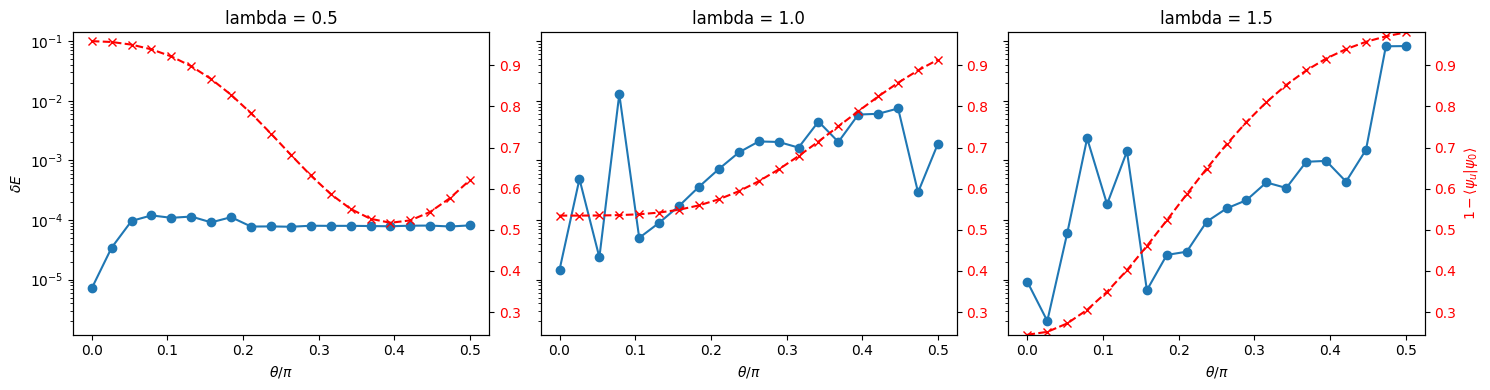

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

# Find global min/max for infidelities to set shared y-limits
inf_min = min([np.min(infidelities[i]) for i in range(3)])
inf_max = max([np.max(infidelities[i]) for i in range(3)])

axs_inf_list = []
for i, lam in enumerate(lambdas):
    df_lam = df[df['Lambda'] == lam]
    axs[i].plot(df_lam['theta']/np.pi, df_lam['Delta_E'], marker='o')
    # axs[i].plot(df_lam['theta']/np.pi, df_lam['infidelity'], marker='o')
    axs[i].set_title(f'lambda = {lam}')
    axs[i].set_xlabel(r'$\theta/\pi$')
    axs_inf = axs[i].twinx()
    axs_inf.plot(thetas/np.pi, infidelities[i], color='red', marker='x', linestyle='--')
    if i == len(lambdas) - 1:
        axs_inf.set_ylabel(r'$1 - \langle \psi_u | \psi_0 \rangle$', color='red')
    axs_inf.tick_params(axis='y', labelcolor='red')
    axs[i].set_yscale('log')
    axs_inf_list.append(axs_inf)

# Set shared y-limits for all axs_inf
for axs_inf in axs_inf_list:
    axs_inf.set_ylim(inf_min, inf_max)

axs[0].set_ylabel(r'$\delta E$')
plt.tight_layout()
plt.show()

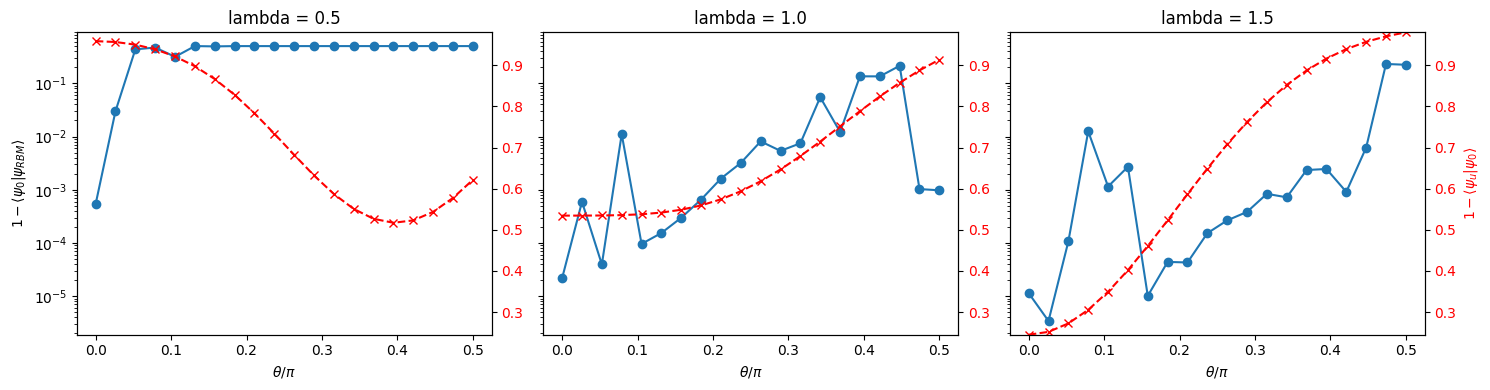

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

# Find global min/max for infidelities to set shared y-limits
inf_min = min([np.min(infidelities[i]) for i in range(3)])
inf_max = max([np.max(infidelities[i]) for i in range(3)])

axs_inf_list = []
for i, lam in enumerate(lambdas):
    df_lam = df[df['Lambda'] == lam]
    axs[i].plot(df_lam['theta']/np.pi, df_lam['infidelity'], marker='o')
    axs[i].set_title(f'lambda = {lam}')
    axs[i].set_xlabel(r'$\theta/\pi$')
    axs_inf = axs[i].twinx()
    axs_inf.plot(thetas/np.pi, infidelities[i], color='red', marker='x', linestyle='--')
    if i == len(lambdas) - 1:
        axs_inf.set_ylabel(r'$1 - \langle \psi_u | \psi_0 \rangle$', color='red')
    axs_inf.tick_params(axis='y', labelcolor='red')
    axs[i].set_yscale('log')
    axs_inf_list.append(axs_inf)

# Set shared y-limits for all axs_inf
for axs_inf in axs_inf_list:
    axs_inf.set_ylim(inf_min, inf_max)

axs[0].set_ylabel(r'$1 - \langle \psi_0 | \psi_{RBM} \rangle$')
plt.tight_layout()
plt.show()

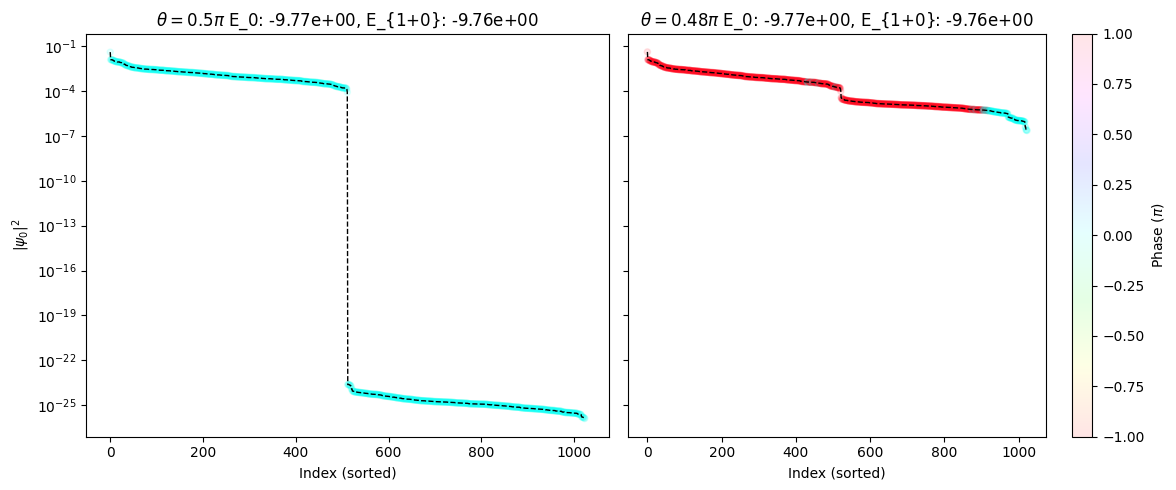

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# First wavefunction
theta = 0.5 * np.pi
Lambda = 0.5
_, _, H = get_TFI_Hamiltonian(L, theta, Lambda)
evals, eigenvectors = nk.exact.lanczos_ed(H, k=3, compute_eigenvectors=True)
psi0 = eigenvectors[:, 0] #+ eigenvectors[:, 1]
sortperm = np.argsort(np.abs(psi0))[::-1]
psi0_sort = psi0[sortperm]
E_var = E_var = 0.5*(evals[0]+evals[1])
# E_var = np.real(np.vdot(psi0, H_sparse @ psi0) / np.vdot(psi0, psi0))

sc = axs[0].scatter(range(len(psi0_sort)), np.abs(psi0_sort)**2, c=np.angle(psi0_sort)/np.pi, cmap='hsv', vmin=-1, vmax=1,s=20,alpha=0.1)
axs[0].plot(range(len(psi0_sort)), np.abs(psi0_sort)**2, lw=1, linestyle="--",color='black')
axs[0].set_yscale('log')

axs[0].set_title(r'$\theta = 0.5\pi$ E_0: {:.2e}, E_{{1+0}}: {:.2e}'.format(evals[0], E_var))
axs[0].set_xlabel('Index (sorted)')
axs[0].set_ylabel(r'$|\psi_0|^2$')

# Second wavefunction
theta = 0.48 * np.pi
_, _, H = get_TFI_Hamiltonian(L, theta, Lambda)
evals, eigenvectors = nk.exact.lanczos_ed(H, k=3, compute_eigenvectors=True)
psi0 = eigenvectors[:, 0] #+ eigenvectors[:, 1]
# E_var = np.real(np.vdot(psi0, H_sparse @ psi0) / np.vdot(psi0, psi0))
E_var = 0.5*(evals[0]+evals[1])
sortperm = np.argsort(np.abs(psi0))[::-1]
psi0_sort = psi0[sortperm]
sc = axs[1].scatter(range(len(psi0_sort)), np.abs(psi0_sort)**2, c=np.angle(psi0_sort)/np.pi, cmap='hsv', vmin=-1, vmax=1,s=20,alpha=0.1)
axs[1].plot(range(len(psi0_sort)), np.abs(psi0_sort)**2, lw=1, linestyle="--",color='black')
axs[1].set_yscale('log')

axs[1].set_title(r'$\theta = 0.48\pi$ E_0: {:.2e}, E_{{1+0}}: {:.2e}'.format(evals[0], E_var))
axs[1].set_xlabel('Index (sorted)')



# Add colorbar
cbar = fig.colorbar(sc, ax=axs[1], orientation='vertical')
cbar.set_label(r'Phase $(\pi)$')

plt.tight_layout()
plt.show()


next, we design a Hamiltonian whose amplitudes are roughly constant while the phases vary rapidly.

In [15]:
def get_ran_phaseH(L,h):
    """
    Constructs an XY model Hamiltonian with complex phases.

    H = -sum_{<i,j>} (S^x_i S^x_j + S^y_i S^y_j) * exp(i * phase(i, j, L))

    Args:
        L: Number of sites along x dimension.

    Returns:
        g: NetKet Lattice object
        hi: NetKet Hilbert space
        H: NetKet Hamiltonian operator
    """
    # g = Lattice(basis_vectors=[[1, 0], [0, 1]], pbc=True, extent=[Lx, Ly])
    g = nk.graph.Chain(length=L, pbc=True)
    
    hi = nk.hilbert.Spin(s=1 / 2, N=g.n_nodes)

    H = sum(- (h+0j) * sigmay(hi,i) for i in g.nodes())
    # H = sum(- 1.0+0j * sigmaz(hi,i) for i in g.nodes())
    # H = 0
    for (i, j) in g.edges():
        H += -0.5* (sigmaz(hi, i) * sigmax(hi, j)) 
    H += H.T.conjugate()
    return g, hi, H

[-13.92314836 -12.96463174 -12.70474815 -12.59226794 -12.01328822
 -11.85442408 -11.7888675  -11.48579233 -11.33850194 -11.27375355]


/tmp/ipykernel_2432690/2590782291.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


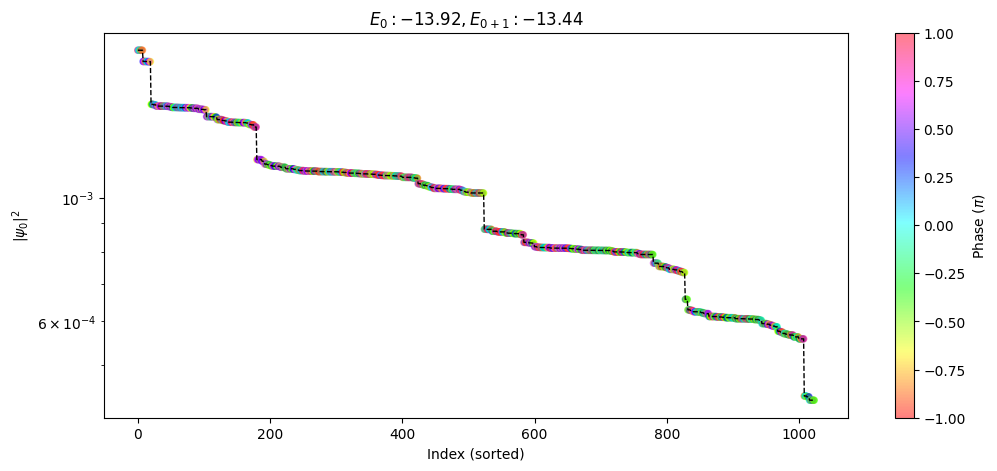

In [16]:
L = 10
_, _, H = get_ran_phaseH(L,0.6)
evals, eigenvectors = nk.exact.lanczos_ed(H, k=10, compute_eigenvectors=True)
print(evals)
psi0 = eigenvectors[:, 0] #+ eigenvectors[:, 1]
sortperm = range(len(psi0))
sortperm = np.argsort(np.abs(psi0))[::-1]
psi0_sort = psi0[sortperm]
avg_phase = np.sum(np.angle(psi0_sort)) / len(psi0_sort)
psi0_sort = np.exp(-1j * avg_phase)*psi0_sort
E_var = E_var = 0.5*(evals[0]+evals[1])
# E_var = np.real(np.vdot(psi0, H_sparse @ psi0) / np.vdot(psi0, psi0))

fig, axs = plt.subplots(1, 1, figsize=(12, 5), sharey=True)

sc = plt.scatter(range(len(psi0_sort)), np.abs(psi0_sort)**2, c=np.angle(psi0_sort)/np.pi, cmap='hsv', vmin=-1, vmax=1,s=20,alpha=0.5)
plt.plot(range(len(psi0_sort)), np.abs(psi0_sort)**2, lw=1, linestyle="--",color='black')
plt.yscale('log')

plt.title(r'$E_0: {:.2f}, E_{{0+1}}: {:.2f}$'.format(evals[0], E_var))
plt.xlabel('Index (sorted)')
plt.ylabel(r'$|\psi_0|^2$')
plt.colorbar(sc, label=r'Phase $(\pi)$')
fig.show()


In [17]:
psi_var = np.abs(psi0)
E_var = np.real(np.vdot(psi_var, H.to_sparse() @ psi_var) / np.vdot(psi_var, psi_var))
E_var, evals[0]

(np.float64(-2.62012633811538e-14), np.float64(-13.923148363775393))

In [398]:
import optimization

params = optimization.generate_params(
    alpha=1,
    seed=1234,
    learning_rate=3e-3,
    n_iter=2000,
    show_progress=True,
    diag_shift=1e-4,
    L = L,
    out=f"../data/ranPhase-model/rbm_optimization",
)
output_file = params["out"] + ".log"
if os.path.exists(output_file):
    print(f"Skipping Hamiltonian, output file already exists.")
else:

    out = optimization.optimize_rbm(H, params)
    optimization.write_output(H, out, params)


  0%|          | 0/2000 [00:00<?, ?it/s]

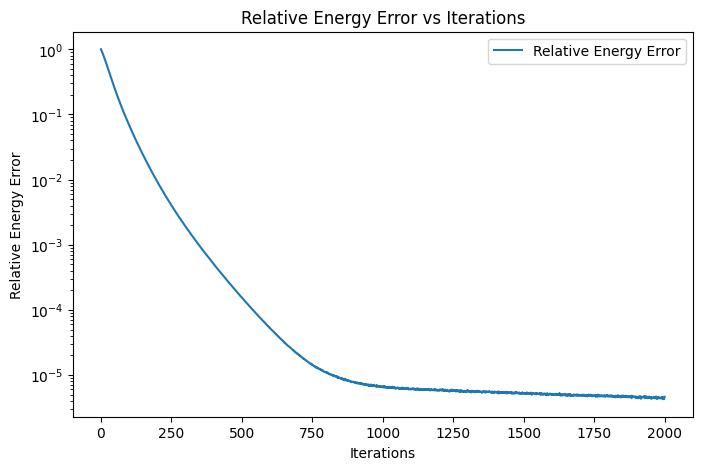

In [399]:
import h5py

# Open the HDF5 file
with h5py.File(params["out"] + ".h5", "r") as f:
    energy = f["en_var_steps"][:]
    e0 = f["exact_ground_energy"][()]

# Compute the relative energy error
relative_energy_error = (energy - e0) / abs(e0)

# Plot the relative energy error
plt.figure(figsize=(8, 5))
plt.plot(range(len(relative_energy_error)), relative_energy_error, linestyle='-', label='Relative Energy Error')
plt.yscale('log')
plt.xlabel("Iterations")
plt.ylabel("Relative Energy Error")
plt.title("Relative Energy Error vs Iterations")
plt.legend()
# plt.grid(True)
plt.show()

In [ ]:
hypotheses = {
    "std_phase" : std_phase,
    "uniform_state_overlap" : uniform_state_overlap,
    "IPR" : ipr,
    "logIPR" : log_ipr,
    "SPCA" : pca_entropy,
    "Renyi_2" : renyi_entropy,
}

# h5_files = [os.path.join("../data/TFI-model", f) for f in os.listdir('../data/TFI-model') if f.endswith('.h5')]
h5_files = [params["out"] + ".h5"]

df = load_outputs_to_dataframe(h5_files)
df = attach_hypotheses_fields(df, hypotheses)
print(len(df))

1


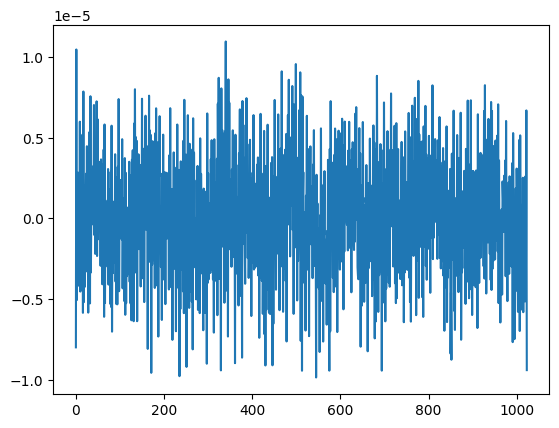

In [421]:
plt.plot(np.abs(psi0_rbm)**2 - np.abs(psi0_exact)**2)

next, we try the same but with a small gap.

[-7.02667418 -7.02667418 -7.02667418 -6.45741483 -7.02667418 -7.02667418
 -6.45741483 -7.02667418 -6.45741483 -7.02667418]


/tmp/ipykernel_2432690/584237753.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


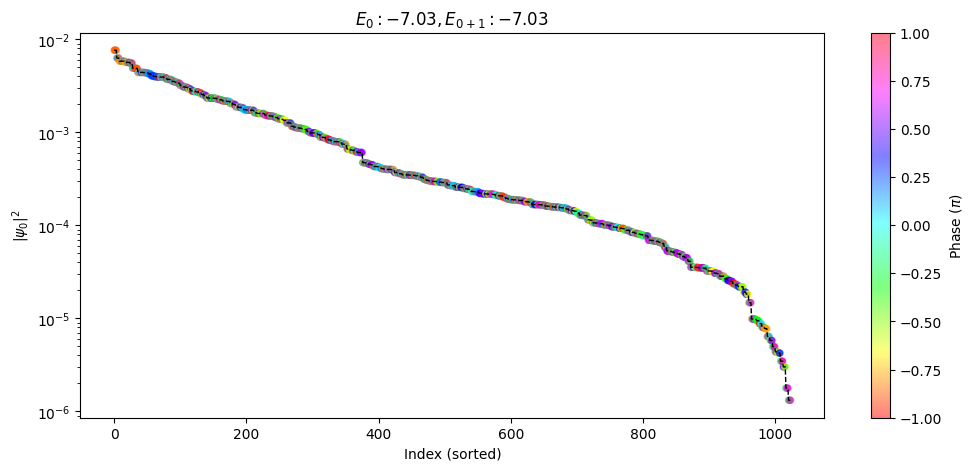

In [22]:
L = 10
_, _, H = get_ran_phaseH(L,0.00)
evals, eigenvectors = nk.exact.lanczos_ed(H, k=10, compute_eigenvectors=True)
print(evals)
psi0 = eigenvectors[:, 0] #+ eigenvectors[:, 1]
sortperm = range(len(psi0))
sortperm = np.argsort(np.abs(psi0))[::-1]
psi0_sort = psi0[sortperm]
avg_phase = np.sum(np.angle(psi0_sort)) / len(psi0_sort)
psi0_sort = np.exp(-1j * avg_phase)*psi0_sort
E_var = E_var = 0.5*(evals[0]+evals[1])
# E_var = np.real(np.vdot(psi0, H_sparse @ psi0) / np.vdot(psi0, psi0))

fig, axs = plt.subplots(1, 1, figsize=(12, 5), sharey=True)

sc = plt.scatter(range(len(psi0_sort)), np.abs(psi0_sort)**2, c=np.angle(psi0_sort)/np.pi, cmap='hsv', vmin=-1, vmax=1,s=20,alpha=0.5)
plt.plot(range(len(psi0_sort)), np.abs(psi0_sort)**2, lw=1, linestyle="--",color='black')
plt.yscale('log')

plt.title(r'$E_0: {:.2f}, E_{{0+1}}: {:.2f}$'.format(evals[0], E_var))
plt.xlabel('Index (sorted)')
plt.ylabel(r'$|\psi_0|^2$')
plt.colorbar(sc, label=r'Phase $(\pi)$')
fig.show()


In [23]:
import optimization

params = optimization.generate_params(
    alpha=1,
    seed=1234,
    learning_rate=3e-3,
    n_iter=2000,
    show_progress=True,
    diag_shift=1e-4,
    h = 0.0,
    L = L,
    out=f"../data/ranPhase-model/rbm_optimization",
)
output_file = params["out"] + ".log"
if os.path.exists(output_file):
    print(f"Skipping Hamiltonian, output file already exists.")
else:

    out = optimization.optimize_rbm(H, params)
    optimization.write_output(H, out, params)


  0%|          | 0/2000 [00:00<?, ?it/s]

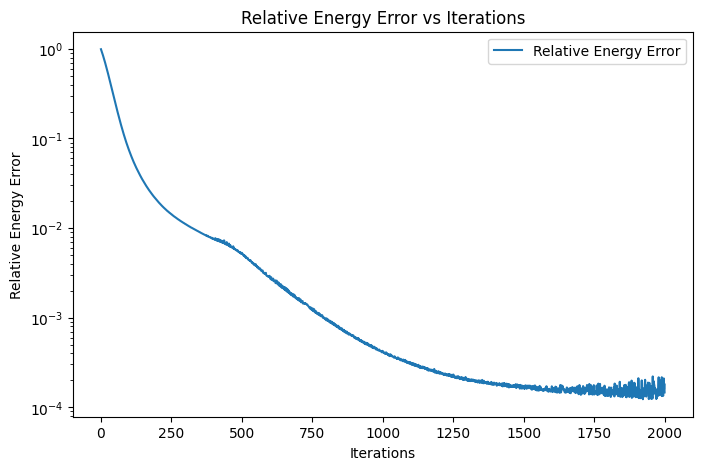

In [24]:
import h5py

# Open the HDF5 file
with h5py.File(params["out"] + ".h5", "r") as f:
    energy = f["en_var_steps"][:]
    e0 = f["exact_ground_energy"][()]

# Compute the relative energy error
relative_energy_error = (energy - e0) / abs(e0)

# Plot the relative energy error
plt.figure(figsize=(8, 5))
plt.plot(range(len(relative_energy_error)), relative_energy_error, linestyle='-', label='Relative Energy Error')
plt.yscale('log')
plt.xlabel("Iterations")
plt.ylabel("Relative Energy Error")
plt.title("Relative Energy Error vs Iterations")
plt.legend()
# plt.grid(True)
plt.show()

In [25]:
hypotheses = {
    "std_phase" : std_phase,
    "uniform_state_overlap" : uniform_state_overlap,
    "IPR" : ipr,
    "logIPR" : log_ipr,
    "SPCA" : pca_entropy,
    "Renyi_2" : renyi_entropy,
}

# h5_files = [os.path.join("../data/TFI-model", f) for f in os.listdir('../data/TFI-model') if f.endswith('.h5')]
h5_files = [params["out"] + ".h5"]

df = load_outputs_to_dataframe(h5_files)
df = attach_hypotheses_fields(df, hypotheses)
print(len(df))

1


In [26]:
df.infidelity

0    0.985781
Name: infidelity, dtype: float64